# Motion Warping

by Andrew Witkin and Zoran Popovic  
1995

Notebook by Jerome Eippers, 2024

In [1]:
%matplotlib widget
import numpy as np
from ipywidgets import widgets, interact
from matplotlib import pyplot as plt

import ipyanimlab as lab

viewer = lab.Viewer(move_speed=5, width=1280, height=720)

In [2]:
character = viewer.import_usd_asset('AnimLabSimpleMale.usd')
character_b = character.duplicate()
character_c = character.duplicate()

character_b.material('/AnimLabSimpleMale/mtl/SuitMaterial').set_albedo(np.array([0.5,1.0,0.5], dtype=np.float32))
character_c.material('/AnimLabSimpleMale/mtl/SuitMaterial').set_albedo(np.array([0.5,0.5,1.0], dtype=np.float32))

xform = np.eye(4, dtype=np.float32)
xform[:3, 3] = [-150, 0, 0]
character_b.set_xform(xform)
xform[:3, 3] = [-300, 0, 0]
character_c.set_xform(xform)

In [3]:
animmap = lab.AnimMapper(character, root_motion=True, match_effectors=True, local_offsets={'Hips':[0, 2, 0]})
animation = lab.import_bvh('../../resources/lafan1/bvh/fightAndSports1_subject1.bvh', anim_mapper=animmap)
animation.quats = lab.utils.remove_quat_discontinuities(animation.quats)

pose_A = animation.quats[695, ...], animation.pos[695, ...]
pose_B = animation.quats[1940, ...], animation.pos[1940, ...]

animation.pos = animation.pos[97:530, ...]
animation.quats = animation.quats[97:530, ...]
frame_count = animation.quats.shape[0]
bone_count = character.bone_count()

In [4]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.end_display()

    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=frame_count-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-18.0, camera_pos=[-370, 280, 350], camera_yaw=-45.0,…

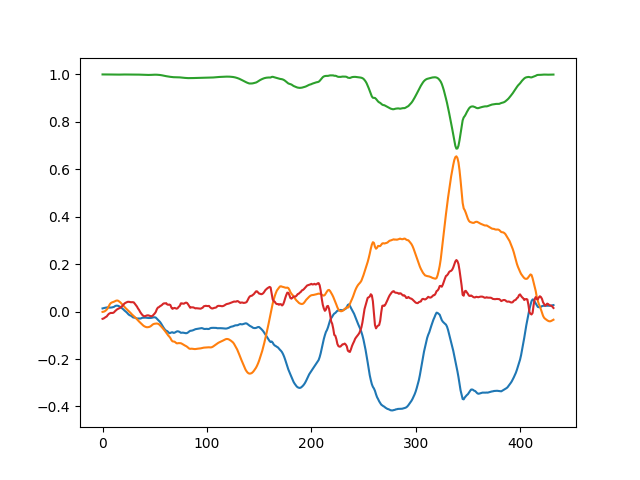

In [5]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(np.linspace(0, frame_count-1, frame_count), animation.quats[:, character.bone_index('LeftUpLeg'), :])

## Time warp inputs

Create a few keyframes for the time remapping. (original frame time, new frame time).

In [6]:
time_wrap_points = np.array([
    [0, 0],
    [40, 40],
    [100, 190],
    [200, 250],
    [430, 400],
    
], dtype=np.int32)

### Spline functions

- cardinal to hermite
- hermite spline

In [7]:
def cardinal_to_hermite(Pts, tension):
    s = (1.0 - tension)*0.5
    hermites = np.zeros([Pts.shape[0] * 2 - 4, Pts.shape[1]])
    hermites[::2, :] = Pts[1:-1]
    hermites[1::2, :] = s * (Pts[2:, :] - Pts[:-2, :])
    return hermites

def hermite(Pt, t):
    #Pt, d/dt, Pt, d/dt  --> column are swapped
    Hm = np.array([[2, 1, -2, 1],[-3, -2, 3, -1],[0, 1, 0, 0],[1, 0, 0, 0]], dtype=np.double)
    Pt = np.dot(Hm, Pt)
    return np.dot(np.column_stack([t**3, t**2, t, np.ones_like(t)]), Pt)

def hermite_spline(P, t):
    segment = int((P.shape[0]/2)-1)
    output = np.zeros([t.shape[0], P.shape[1]])
    index = 0
    for s in range(segment):
        where = np.logical_and(t >= s, t <= s+1)
        output[where, :] = hermite(P[index:index+4, ...], t[where] - s)
        index += 2
    return output

### Mapping as hermite 
This will return an hermite spline, but the mapping is not linear when requesting input frames

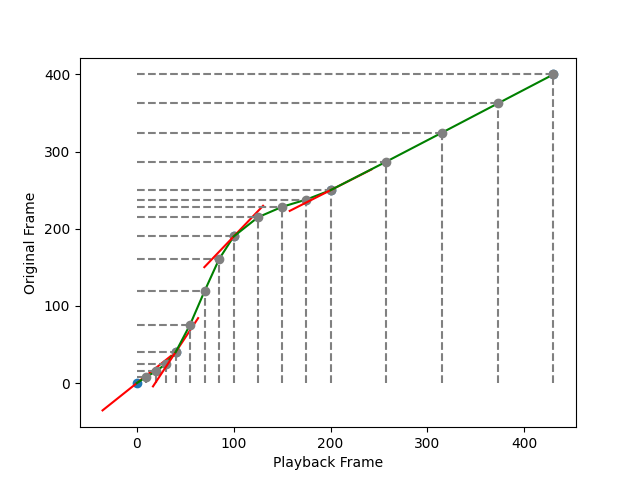

In [8]:
cardinal_pts = np.concatenate([time_wrap_points[0:1], time_wrap_points, time_wrap_points[-1:]])
p_to_hermite = cardinal_to_hermite(cardinal_pts, 0)
p_to_hermite = (p_to_hermite[:, 1]/(p_to_hermite[:, 0]+1e-8))
p_to_hermite[::2] = time_wrap_points[:,1]

keytimes = time_wrap_points[:,0]
scales = keytimes[1:] - keytimes[:-1]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(time_wrap_points[:, 0], time_wrap_points[:, 1])
ax.set_xlabel("Playback Frame")
ax.set_ylabel("Original Frame")

def plot_tangent(ax, tangent, x, y, scale=1):
    dx = 1
    norm = np.sqrt(dx**2 + tangent**2) / scale
    x = (x-dx/norm, x+dx/norm)
    y = (y-tangent/norm, y+tangent/norm)
    ax.plot(x, y, 'r-')
    
for i in range(scales.shape[0]):
    pt = p_to_hermite[i*2:i*2+4].copy()
    plot_tangent(ax, pt[1], keytimes[i], pt[0], 50)
                 
    pt[1::2] *= scales[i]
    curve = hermite(pt, np.linspace(0,1,5))
    ax.plot(np.linspace(keytimes[i], keytimes[i+1],5), curve, '-', color='green')

    for j in range(1,5):
        x = keytimes[i+1]*(j/4.0) + keytimes[i]*(1.0-j/4.0)
        y = curve[j]
        ax.plot(x, y, 'o', color='gray')
        ax.plot((x,x), (0,y), '--', color='gray')
        ax.plot((0,x), (y,y), '--', color='gray')
    

### Resample the hermite spline
we will remap the hermite curves to have pure frame 1, 2, 3, ... n to new frame.

In [9]:
def resample_curve(keytimes, p_to_hermite):
    keytimes = keytimes.astype(np.int32)
    scales = keytimes[1:] - keytimes[:-1]
    resampled = np.zeros([keytimes[-1]-keytimes[0]+1, 2], dtype=np.float32)
    
    for i in range(scales.shape[0]):
        pt = p_to_hermite[i*2:i*2+4].copy()
        pt[1::2] *= scales[i]
        frames = np.linspace(keytimes[i], keytimes[i+1], keytimes[i+1]-keytimes[i]+1)
        framevalues = hermite(pt, np.linspace(0, 1, keytimes[i+1]-keytimes[i]+1))
        resampled[keytimes[i]-keytimes[0]:keytimes[i+1]+1-keytimes[0], 0] = frames
        resampled[keytimes[i]-keytimes[0]:keytimes[i+1]+1-keytimes[0], 1] = framevalues
    return resampled

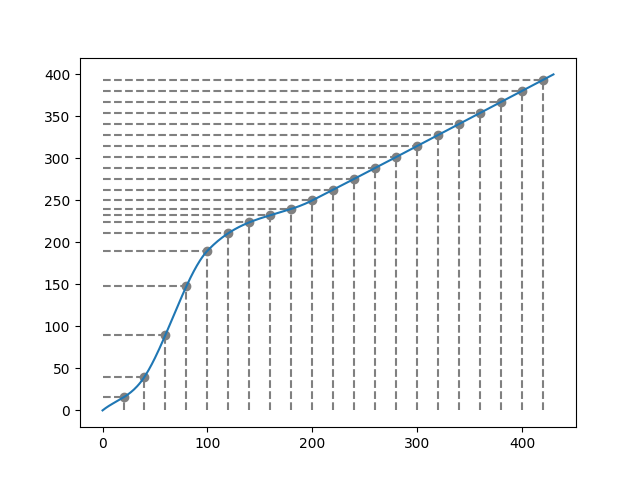

In [10]:
timewarp_curve = resample_curve(keytimes, p_to_hermite)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


count =  timewarp_curve[::20, 0].shape[0]
for j in range(1,count):
    x = timewarp_curve[::20, 0][j]
    y = timewarp_curve[::20, 1][j]
    ax.plot(x, y, 'o', color='gray')
    ax.plot((x,x), (0,y), '--', color='gray')
    ax.plot((0,x), (y,y), '--', color='gray')

ax.plot(timewarp_curve[:, 0], timewarp_curve[:, 1])

### Final functions to map

- build curve will return a mapping of shape [old x, new x]
- warp_curve take remapping array coming from build_curve and any value array of len x to return the new array value remapped with the value.

In [11]:
def build_curve(time_wrap_points):
    cardinal_pts = np.concatenate([time_wrap_points[0:1], time_wrap_points, time_wrap_points[-1:]])
    p_to_hermite = cardinal_to_hermite(cardinal_pts, 0)
    p_to_hermite = (p_to_hermite[:, 1]/(p_to_hermite[:, 0]+1e-8))
    p_to_hermite[::2] = time_wrap_points[:,1]
    return resample_curve(time_wrap_points[:,0], p_to_hermite)

def warp_curve(timewarp_curve, curve):
    floor_curve = np.floor(timewarp_curve[:,1]).astype(np.int32)
    t = timewarp_curve[:,1] - floor_curve
    t = t[np.newaxis, :].repeat(np.prod(curve.shape[1:]), axis=-1).reshape(timewarp_curve.shape[0], *curve.shape[1:])
    return ((1.0 - t ) * curve[floor_curve, ...]) + (t * curve[floor_curve+1, ...])

## Time Warp

In [12]:
timewarp_curve = build_curve(time_wrap_points)

new_q = warp_curve(timewarp_curve, animation.quats)
new_q = lab.utils.quat_normalize(new_q)
new_p = warp_curve(timewarp_curve, animation.pos)

In [13]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    pwt = new_p[frame,...].copy()
    qwt = new_q[frame,...]
    b = lab.utils.quat_to_mat(qwt, pwt)
    
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.draw(character_b, b)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.draw(character_b, b)
    viewer.end_display()

    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=430)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-22.79999999999999, camera_pos=[-293.42878914169285, …

## Pose Warp

now we have (time, pose) data.

In [15]:
# create keyframes
keyframes = np.array([0, 190, 220, 320, 349, 405, 432], dtype=np.int32)
keyframes_q = np.concatenate([
    animation.quats[np.newaxis, 0, ...],
    pose_A[0][np.newaxis, ...],
    animation.quats[np.newaxis, 220, ...],
    animation.quats[np.newaxis, 320, ...],
    pose_B[0][np.newaxis, ...],
    animation.quats[np.newaxis, 405, ...],
    animation.quats[np.newaxis, 432, ...],
])
keyframes_p = np.concatenate([
    animation.pos[np.newaxis, 0, ...],
    pose_A[1][np.newaxis, ...],
    animation.pos[np.newaxis, 220, ...],
    animation.pos[np.newaxis, 320, ...],
    pose_B[1][np.newaxis, ...],
    animation.pos[np.newaxis, 405, ...],
    animation.pos[np.newaxis, 432, ...],
])

# align them with animation (by using the root from the animation)
keyframes_q[:, 0, :] = animation.quats[keyframes, 0, :]
keyframes_p[:, 0, :] = animation.pos[keyframes, 0, :]

In [16]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...]).copy()
    q = (anim.quats[frame,...])
    a = lab.utils.quat_to_mat(q, p)
    
    # show input frame 1
    p = (anim.pos[190,...]).copy()
    q = (anim.quats[190,...])
    p[0, 0] += 150
    b = lab.utils.quat_to_mat(q, p)
    
    # show input frame 2
    p = (anim.pos[349,...]).copy()
    q = (anim.quats[349,...])
    p[0, 0] += 300
    c = lab.utils.quat_to_mat(q, p)
    
    # show target 1
    p = keyframes_p[1].copy()
    q = keyframes_q[1]
    p[0, 0] += 150
    p[0, 2] += 100
    d = lab.utils.quat_to_mat(q, p)
    
    # show target 2
    p = keyframes_p[4].copy()
    q = keyframes_q[4]
    p[0, 0] += 300
    p[0, 2] += 100
    e = lab.utils.quat_to_mat(q, p)    
    
    viewer.set_shadow_poi(p[0])
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.draw(character, b)
    viewer.draw(character, c)
    viewer.draw(character, d)
    viewer.draw(character, e)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.draw(character, b)
    viewer.draw(character, c)
    viewer.draw(character, d)
    viewer.draw(character, e)
    viewer.end_display()

    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=frame_count-1)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-26.79999999999998, camera_pos=[-293.42878914169285, …

### compute the input poses as offsets

In [17]:
# compute local offset
local_offset_poses = lab.utils.qp_mul(lab.utils.qp_inv((animation.quats[keyframes], animation.pos[keyframes])), (keyframes_q, keyframes_p))

### warp the offsets

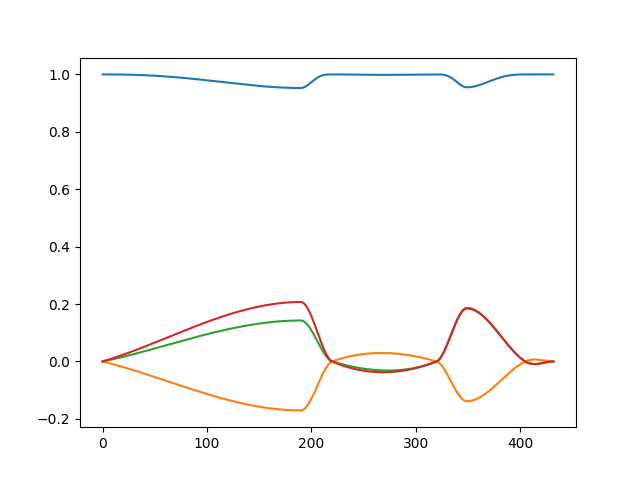

In [19]:
warp_quats = np.zeros([frame_count, bone_count, 4], dtype=np.float32)
warp_pos = np.zeros([frame_count, bone_count, 3], dtype=np.float32)

warp_pt = np.zeros([keyframes.shape[0], 2], dtype=np.float32)
warp_pt[:, 0] = keyframes

steps = np.linspace(0, frame_count -1, frame_count)

for i in range(bone_count):
    for j in range(4):
        for k in range(keyframes.shape[0]):
            warp_pt[k, 1] = local_offset_poses[0][k, i, j]
        warp_quats[:, i, j] = build_curve(warp_pt)[:,1]
    for j in range(3):
        for k in range(keyframes.shape[0]):
            warp_pt[k, 1] = local_offset_poses[1][k, i, j]
        warp_pos[:, i, j] = build_curve(warp_pt)[:,1]

warp_quats = lab.utils.quat_normalize(warp_quats)

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(steps, warp_quats[:, 6, :])

In [20]:
# compute the new animation by adding the compute warped offsets
full_warp_q, full_warp_p = lab.utils.qp_mul((animation.quats,animation.pos) , (warp_quats, warp_pos))

def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    pwt = full_warp_p[frame,...]
    qwt = full_warp_q[frame,...]
    b = lab.utils.quat_to_mat(qwt, pwt)
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.draw(character_b, b)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.draw(character_b, b)
    viewer.end_display()

    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=430)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-20.599999999999973, camera_pos=[27.5122710561716, 21…

## Timewarp the warped offsets

In [21]:
new_warp_q = warp_curve(timewarp_curve, warp_quats)
new_warp_q = lab.utils.quat_normalize(new_warp_q)
new_warp_p = warp_curve(timewarp_curve, warp_pos)

full_warp_q, full_warp_p = lab.utils.qp_mul((new_q,new_p) , (new_warp_q, new_warp_p))

In [22]:
def render(frame):
    
    anim = animation
    p = (anim.pos[frame,...])
    q = (anim.quats[frame,...])
        
    a = lab.utils.quat_to_mat(q, p)
    viewer.set_shadow_poi(p[0])
    
    pwt = new_p[frame,...]
    qwt = new_q[frame,...]
    b = lab.utils.quat_to_mat(qwt, pwt)
    
    pw = full_warp_p[frame,...]
    qw = full_warp_q[frame,...]
    c = lab.utils.quat_to_mat(qw, pw)
    
    viewer.begin_shadow()
    viewer.draw(character, a)
    viewer.draw(character_b, b)
    viewer.draw(character_c, c)
    viewer.end_shadow()
    
    viewer.begin_display()
    viewer.draw_ground()
    viewer.draw(character, a)
    viewer.draw(character_b, b)
    viewer.draw(character_c, c)
    viewer.end_display()

    viewer.execute_commands()
    
interact(
    render, 
    frame=lab.Timeline(max=430)
)
viewer

interactive(children=(Timeline(value=0, children=(Play(value=0, description='play', interval=33, layout=Layout…

Viewer(camera_far=2800.0, camera_near=20.0, camera_pitch=-16.19999999999997, camera_pos=[-214.55383986182562, …